In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
# from influxdb import InfluxDBClient
import statsmodels.tsa.api as smt
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
pd.set_option("display.max_rows",2000)
pd.set_option("display.max_columns",None)
plt.style.use('Solarize_Light2')

## Importing the Dataset

In [2]:

# --- country data (country, region, Income Group)
country = pd.read_csv('CSV_files/Metadata_Country.csv')

# --- Population data ( Population countrywise)
population = pd.read_csv('CSV_files/country_population.csv')

# --- Fertilty data( Fertility_rate countrywise)
fertility_rate = pd.read_csv('CSV_files/fertility_rate.csv')

# ---  Life_expectancy data(avg Life_expectancy country wise)
life_expectancy = pd.read_csv('CSV_files/life_expectancy.csv')

# --- Migration data(number of immigranted people - number of emmigranted people)
net_migration = pd.read_csv('CSV_files/Net_migration.csv',engine='python')

# -- Indicator data (Birth_rate, death_rate,age_group_population,gender_population)
world_indicator = pd.read_excel('CSV_files/world_indicator.xlsx')

# Data Preprocessing

## Filtering the unwanted variables from each dataset

In [3]:
# -- Country data
country=country[['Country Code','Region','IncomeGroup']]


unwanted_columns=['Indicator Name','Indicator Code','Country Name'] # Unwanted columns for the analysis

# -- Population data
population.drop(unwanted_columns[:2],axis=1,inplace=True)

# --Fertility data
fertility_rate.drop(unwanted_columns,axis=1,inplace=True)

# # --Life_expectancy data
life_expectancy.drop(unwanted_columns,axis=1,inplace=True)

# # --Net_migration data
net_migration.drop(unwanted_columns+['2017','2018','2019'],axis=1,inplace=True) # Analysing the records till year 2016

# # --World_Indicator data
world_indicator.drop(['2017','2018'],axis=1,inplace=True) # Analysing the records till year 2016

## Melting the columns to rows

In [4]:
# --- Years range for melting the columns to rows
years=[str(i) for i in range(1960,2017)]

# --- Constant columns for melting
variables=['Country Name','Country Code']

In [5]:
population=pd.melt(population,id_vars=variables,
                      value_vars=years,
                      var_name='Year',
                      value_name='Population')

fertility_rate=pd.melt(fertility_rate,id_vars=variables[1],
                      value_vars=years,
                      var_name='Year',
                      value_name='Fertility_rate')

life_expectancy=pd.melt(life_expectancy,id_vars=variables[1],
                      value_vars=years,
                      var_name='Year',
                      value_name='Life_expectancy')

net_migration=pd.melt(net_migration,id_vars=variables[1],
                      value_vars=years,
                      var_name='Year',
                      value_name='Net_migration')

world_indicator=pd.melt(world_indicator,id_vars=variables+['Series Name'],
                      value_vars=years,
                      var_name='Year',
                      value_name='Values')

In [82]:
life_expectancy.head()

,Country Code,Year,Life_expectancy
0,ABW,1960,65.662
1,AFG,1960,32.292
2,AGO,1960,33.251
3,ALB,1960,62.279
4,AND,1960,NaN


### Converting rows to columns using pivot table 

In [6]:
world_indicator=world_indicator[['Country Code','Year','Series Name','Values']].pivot_table(values='Values',
                                                index=['Country Code','Year'],columns='Series Name',aggfunc=np.sum)

In [7]:
world_indicator.reset_index(level=['Country Code','Year'],inplace=True)

## Merging the dataset 

In [8]:
df = pd.merge(country, population, how='left', on='Country Code')
df = pd.merge(df, life_expectancy, how='left', on=['Country Code', 'Year'])
df = pd.merge(df, fertility_rate, how='left', on=['Country Code', 'Year'])
df = pd.merge(df, net_migration, how='left', on=['Country Code', 'Year'])
df = pd.merge(df, world_indicator, how='left', on=['Country Code', 'Year'])

In [9]:
df.sort_values(by=['Country Name','Year'],inplace=True)
df.reset_index(drop=True,inplace=True)

In [10]:
df.head()

,Country Code,Region,IncomeGroup,Country Name,Year,Population,Life_expectancy,Fertility_rate,Net_migration,"Age population, age 0, male, interpolated","Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)",GDP growth (annual %),Population ages 0-14 (% of total),"Population ages 0-14, female",Population ages 15-64 (% of total),"Population ages 15-64, female","Population ages 15-64, male","Population ages 15-64, total",Population ages 65 and above (% of total),"Population ages 65 and above, female","Population, female","Population, female (% of total)","Population, total"
0,AFG,South Asia,Low income,Afghanistan,1960,8996351.0,32.292,7.45,NaN,178269,51.279,32.219,..,..,..,..,..,..,..,2.79831,115755,..,..,..
1,AFG,South Asia,Low income,Afghanistan,1961,9166764.0,32.742,7.45,NaN,182276,51.373,31.649,..,..,..,..,..,..,..,2.80813,118864,..,..,..
2,AFG,South Asia,Low income,Afghanistan,1962,9345868.0,33.185,7.45,-20000.0,186730,51.457,31.093,..,..,..,..,..,..,..,2.80411,121786,..,..,..
3,AFG,South Asia,Low income,Afghanistan,1963,9533954.0,33.624,7.45,NaN,191614,51.53,30.551,..,..,..,..,..,..,..,2.78617,124431,..,..,..
4,AFG,South Asia,Low income,Afghanistan,1964,9731361.0,34.060,7.45,NaN,196930,51.589,30.022,..,..,..,..,..,..,..,2.75422,126641,..,..,..


In [11]:
# Removing Unwanted Columns Level1:

df.drop(['Country Code','Age population, age 0, male, interpolated'],axis=1,inplace=True)
df.head()

,Region,IncomeGroup,Country Name,Year,Population,Life_expectancy,Fertility_rate,Net_migration,"Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)",GDP growth (annual %),Population ages 0-14 (% of total),"Population ages 0-14, female",Population ages 15-64 (% of total),"Population ages 15-64, female","Population ages 15-64, male","Population ages 15-64, total",Population ages 65 and above (% of total),"Population ages 65 and above, female","Population, female","Population, female (% of total)","Population, total"
0,South Asia,Low income,Afghanistan,1960,8996351.0,32.292,7.45,NaN,51.279,32.219,..,..,..,..,..,..,..,2.79831,115755,..,..,..
1,South Asia,Low income,Afghanistan,1961,9166764.0,32.742,7.45,NaN,51.373,31.649,..,..,..,..,..,..,..,2.80813,118864,..,..,..
2,South Asia,Low income,Afghanistan,1962,9345868.0,33.185,7.45,-20000.0,51.457,31.093,..,..,..,..,..,..,..,2.80411,121786,..,..,..
3,South Asia,Low income,Afghanistan,1963,9533954.0,33.624,7.45,NaN,51.53,30.551,..,..,..,..,..,..,..,2.78617,124431,..,..,..
4,South Asia,Low income,Afghanistan,1964,9731361.0,34.060,7.45,NaN,51.589,30.022,..,..,..,..,..,..,..,2.75422,126641,..,..,..


### Adjusting the population accuracy

In [12]:
val=pd.DataFrame(map(lambda i,j: i if (j=='..' or j!=j) else j if j!=i else i,df['Population'],df['Population, total']))

df.insert(loc=6, column='Total_Population', value=val)

df.drop(['Population','Population, total'],axis=1,inplace=True)

In [13]:
df.head()

,Region,IncomeGroup,Country Name,Year,Life_expectancy,Total_Population,Fertility_rate,Net_migration,"Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)",GDP growth (annual %),Population ages 0-14 (% of total),"Population ages 0-14, female",Population ages 15-64 (% of total),"Population ages 15-64, female","Population ages 15-64, male","Population ages 15-64, total",Population ages 65 and above (% of total),"Population ages 65 and above, female","Population, female","Population, female (% of total)"
0,South Asia,Low income,Afghanistan,1960,32.292,8996351.0,7.45,NaN,51.279,32.219,..,..,..,..,..,..,..,2.79831,115755,..,..
1,South Asia,Low income,Afghanistan,1961,32.742,9166764.0,7.45,NaN,51.373,31.649,..,..,..,..,..,..,..,2.80813,118864,..,..
2,South Asia,Low income,Afghanistan,1962,33.185,9345868.0,7.45,-20000.0,51.457,31.093,..,..,..,..,..,..,..,2.80411,121786,..,..
3,South Asia,Low income,Afghanistan,1963,33.624,9533954.0,7.45,NaN,51.53,30.551,..,..,..,..,..,..,..,2.78617,124431,..,..
4,South Asia,Low income,Afghanistan,1964,34.060,9731361.0,7.45,NaN,51.589,30.022,..,..,..,..,..,..,..,2.75422,126641,..,..


### Checking for characters or words other than alphanumerics

In [14]:
(df.isnull().sum())+((df=='..').sum())

Region                                        2622
IncomeGroup                                   2622
Country Name                                     0
Year                                             0
Life_expectancy                               1244
Total_Population                               106
Fertility_rate                                1221
Net_migration                                12363
Birth rate, crude (per 1,000 people)          3600
Death rate, crude (per 1,000 people)          3624
GDP growth (annual %)                         6087
Population ages 0-14 (% of total)             5924
Population ages 0-14, female                  5955
Population ages 15-64 (% of total)            5920
Population ages 15-64, female                 5955
Population ages 15-64, male                   5955
Population ages 15-64, total                  5955
Population ages 65 and above (% of total)     3998
Population ages 65 and above, female          4001
Population, female             

In [15]:
# Converting the characters which has '..' 
df[df=='..']=np.nan

In [16]:
df.head()

,Region,IncomeGroup,Country Name,Year,Life_expectancy,Total_Population,Fertility_rate,Net_migration,"Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)",GDP growth (annual %),Population ages 0-14 (% of total),"Population ages 0-14, female",Population ages 15-64 (% of total),"Population ages 15-64, female","Population ages 15-64, male","Population ages 15-64, total",Population ages 65 and above (% of total),"Population ages 65 and above, female","Population, female","Population, female (% of total)"
0,South Asia,Low income,Afghanistan,1960,32.292,8996351.0,7.45,NaN,51.279,32.219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.79831,115755,NaN,NaN
1,South Asia,Low income,Afghanistan,1961,32.742,9166764.0,7.45,NaN,51.373,31.649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.80813,118864,NaN,NaN
2,South Asia,Low income,Afghanistan,1962,33.185,9345868.0,7.45,-20000.0,51.457,31.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.80411,121786,NaN,NaN
3,South Asia,Low income,Afghanistan,1963,33.624,9533954.0,7.45,NaN,51.53,30.551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78617,124431,NaN,NaN
4,South Asia,Low income,Afghanistan,1964,34.060,9731361.0,7.45,NaN,51.589,30.022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.75422,126641,NaN,NaN


In [17]:
# Removing unwanted rows:
df=df[df['Region'].notna()]
df.head()

,Region,IncomeGroup,Country Name,Year,Life_expectancy,Total_Population,Fertility_rate,Net_migration,"Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)",GDP growth (annual %),Population ages 0-14 (% of total),"Population ages 0-14, female",Population ages 15-64 (% of total),"Population ages 15-64, female","Population ages 15-64, male","Population ages 15-64, total",Population ages 65 and above (% of total),"Population ages 65 and above, female","Population, female","Population, female (% of total)"
0,South Asia,Low income,Afghanistan,1960,32.292,8996351.0,7.45,NaN,51.279,32.219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.79831,115755,NaN,NaN
1,South Asia,Low income,Afghanistan,1961,32.742,9166764.0,7.45,NaN,51.373,31.649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.80813,118864,NaN,NaN
2,South Asia,Low income,Afghanistan,1962,33.185,9345868.0,7.45,-20000.0,51.457,31.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.80411,121786,NaN,NaN
3,South Asia,Low income,Afghanistan,1963,33.624,9533954.0,7.45,NaN,51.53,30.551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78617,124431,NaN,NaN
4,South Asia,Low income,Afghanistan,1964,34.060,9731361.0,7.45,NaN,51.589,30.022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.75422,126641,NaN,NaN


### Missing Values & Imputation

In [18]:
pd.DataFrame(round(df.isnull().sum()/df.shape[0]*100,2),columns=['Missing_values in (%)'])

,Missing_values in (%)
Region,0.00
IncomeGroup,0.00
Country Name,0.00
Year,0.00
Life_expectancy,10.06
Total_Population,0.86
Fertility_rate,9.87
Net_migration,82.84
"Birth rate, crude (per 1,000 people)",7.91
"Death rate, crude (per 1,000 people)",8.10


<b>Removing the columns which has more than 50% of missing values</b>

In [19]:
bandwidth_50_col=pd.DataFrame(round(df.isnull().sum()/df.shape[0]*100),columns=['Missing_values in (%)'])
col=bandwidth_50_col[bandwidth_50_col['Missing_values in (%)']>50].index
df.drop(col,axis=1,inplace=True)
df.head()

,Region,IncomeGroup,Country Name,Year,Life_expectancy,Total_Population,Fertility_rate,"Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)",GDP growth (annual %),Population ages 0-14 (% of total),"Population ages 0-14, female",Population ages 15-64 (% of total),"Population ages 15-64, female","Population ages 15-64, male","Population ages 15-64, total",Population ages 65 and above (% of total),"Population ages 65 and above, female","Population, female","Population, female (% of total)"
0,South Asia,Low income,Afghanistan,1960,32.292,8996351.0,7.45,51.279,32.219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.79831,115755,NaN,NaN
1,South Asia,Low income,Afghanistan,1961,32.742,9166764.0,7.45,51.373,31.649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.80813,118864,NaN,NaN
2,South Asia,Low income,Afghanistan,1962,33.185,9345868.0,7.45,51.457,31.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.80411,121786,NaN,NaN
3,South Asia,Low income,Afghanistan,1963,33.624,9533954.0,7.45,51.53,30.551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78617,124431,NaN,NaN
4,South Asia,Low income,Afghanistan,1964,34.060,9731361.0,7.45,51.589,30.022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.75422,126641,NaN,NaN


# Imputation Process:</br>

### Target Variable - Total_Population
<p>
For Imputing Total_popualtion we cannot use Traditional use mean/Median Imputation.<br>
We need to use other methods to impute since the records are distinct metric. <br>
    
<b>Method_1 Population_Projection:</b><br>
                 Population projections are simply mathematical formulas that use current populations and<br>
rates of growth to estimate future populations.<br>

               Nt = P e^(r * t)

               Nt  = Number of People at Future time
                P  = Present Population
                e  = base of the natural logarithms (2.71828)
                r  = natrual Increase ( (Birth_rate - Death_rate)/100)
                t  = represents the time period involved
    
By using population Projection formula we can impute the Popualtion.<br>
However, Projections for specific countries and age groups have not been as accurate.<br>In general, projections of future population size tend to be more uncertain, or less accurate:
<ul><ul>
<li>For less developed countries than for more developed countries.
</li>
<li>  
For smaller countries than larger ones.
</li>
<li>
For younger and older age groups than for middle age groups, because incorrect assumptions<br> about fertility and mortality have a greater effect at older and younger ages
    </li>
    <li>
For longer periods (more than two decades) than shorter periods, because of the compounding effects of incorrect assumptions over time.
    </li>
    </ul></ul>

<b>Method_2: Using Population_growth_rate:</b><br>
We can populate new field (Population_growth_rate) using population feature and impute those ,since we have seen that<br> 
the Population for each country is increasing every year.
This is used for Instead of Reverse projection to find the population for the past year from present year.

For populaiton projection or to find the population for future year. we cannot use growth rate, instead we can use 
other varibales to Impute like<br>
  
                  population=present_population + no. of births - no.of deaths + Net_migration 
                  
                      * Net_Migration  = No. of immigrants - No.of emmigrants
          
</p>

In [20]:

# -- creating new columns (population growth rate)

val=np.where(df['Year']=="1960",0,
    np.where((df['Total_Population'].notna()) & (df['Total_Population'].shift().notna()),
    ((df['Total_Population']-df['Total_Population'].shift())/df['Total_Population'].shift()*100).round(1),np.nan))

df.insert(loc=6, column='Population_growth_rate(%)', value=val)

In [21]:
df.head()

,Region,IncomeGroup,Country Name,Year,Life_expectancy,Total_Population,Population_growth_rate(%),Fertility_rate,"Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)",GDP growth (annual %),Population ages 0-14 (% of total),"Population ages 0-14, female",Population ages 15-64 (% of total),"Population ages 15-64, female","Population ages 15-64, male","Population ages 15-64, total",Population ages 65 and above (% of total),"Population ages 65 and above, female","Population, female","Population, female (% of total)"
0,South Asia,Low income,Afghanistan,1960,32.292,8996351.0,0.0,7.45,51.279,32.219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.79831,115755,NaN,NaN
1,South Asia,Low income,Afghanistan,1961,32.742,9166764.0,1.9,7.45,51.373,31.649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.80813,118864,NaN,NaN
2,South Asia,Low income,Afghanistan,1962,33.185,9345868.0,2.0,7.45,51.457,31.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.80411,121786,NaN,NaN
3,South Asia,Low income,Afghanistan,1963,33.624,9533954.0,2.0,7.45,51.53,30.551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78617,124431,NaN,NaN
4,South Asia,Low income,Afghanistan,1964,34.060,9731361.0,2.1,7.45,51.589,30.022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.75422,126641,NaN,NaN


<b> changing the datatype of the columns </b>

In [22]:
df['Year']=df['Year'].astype('int')
categorical_col=df.iloc[:,4:].describe(include='O').columns

for i in categorical_col:
    df[i]=df[i].astype('float')

# Imputation 

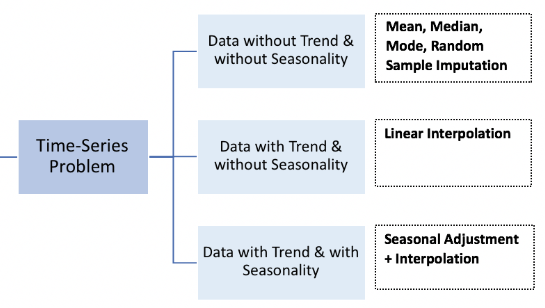

<b>Imputing the Life_expectancy column:</b>

Removing the country which doesn't have data for all years(1960 - 2016)

In [23]:
dum=pd.unique(df[(df['Life_expectancy'].isna()) & (df['Fertility_rate'].isna()) &
                 (df['Year'].isin([i for i in range(1960,2015)]))]['Country Name'])
df=df[~df['Country Name'].isin(dum)]

In [24]:
# Country Name with null life Expectany value
null_life_exp=pd.unique(df[df['Life_expectancy'].isna()]['Country Name'])

Text(0.5, 1.0, 'Life_expectancy Before Imputataion')

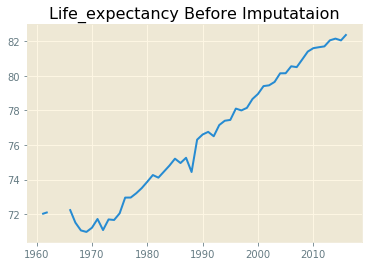

In [25]:
plt.plot(pd.unique(df['Year']),df[df['Country Name'].isin(null_life_exp)]['Life_expectancy'])
plt.title("Life_expectancy Before Imputataion")

Since there is a trend we can cubic interpolation for time series data

Text(0.5, 1.0, 'Life_expectancy After Imputataion')

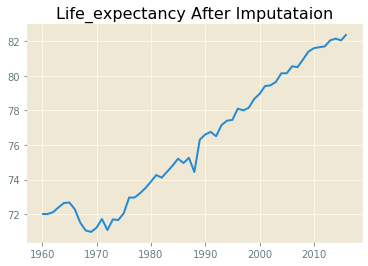

In [26]:
index=df[df['Country Name'].isin(null_life_exp)]['Life_expectancy'].index
df.loc[index,'Life_expectancy']=df[df['Country Name'].isin(null_life_exp)]['Life_expectancy'].interpolate(method='cubic')
df.loc[index,'Life_expectancy']=df[df['Country Name'].isin(null_life_exp)]['Life_expectancy'].interpolate(method='linear',limit_direction="both")
plt.plot(pd.unique(df['Year']),df[df['Country Name'].isin(null_life_exp)]['Life_expectancy'])
plt.title("Life_expectancy After Imputataion")

<b>Imputing the  Fertility_rate column:</b>

In [27]:
null_fertility=pd.unique(df[df['Fertility_rate'].isna()]['Country Name'])

Text(0.5, 1.0, 'Fertility_rate Before Imputataion')

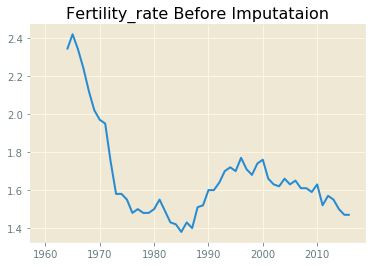

In [28]:
plt.plot(pd.unique(df['Year']),df[df['Country Name'].isin(null_fertility)]['Fertility_rate'])
plt.title("Fertility_rate Before Imputataion")

Text(0.5, 1.0, 'Fertility_rate After Imputataion')

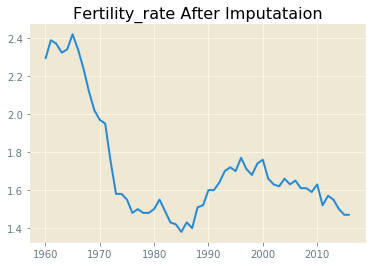

In [29]:
index=df[df['Country Name'].isin(null_fertility)]['Fertility_rate'].index
df.loc[index,'Fertility_rate']=df[df['Country Name'].isin(null_fertility)]['Fertility_rate'].interpolate(method='cubic')

plt.plot(pd.unique(df['Year']),df[df['Country Name'].isin(null_fertility)]['Fertility_rate'])
plt.title("Fertility_rate After Imputataion")

<b>Imputing the  Total_population column:</b>

In [30]:
null_total_population=pd.unique(df[df['Total_Population'].isna()]['Country Name'])
null_total_population

array(['Eritrea', 'Kuwait'], dtype=object)

Text(0.5, 1.0, 'Total Population for Kuwait before Imputaion')

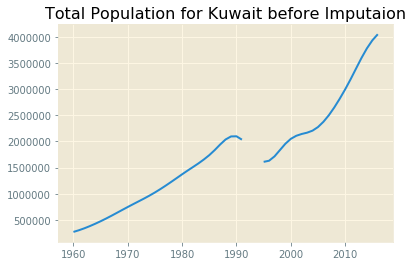

In [31]:
plt.plot(pd.unique(df['Year']),df[df['Country Name']==null_total_population[1]]['Total_Population'])
plt.title("Total Population for Kuwait before Imputaion")

For Kuwait since we have before and after data points for interpolation we can use cubic interpolation

Text(0.5, 1.0, 'Total Population for Kuwait After Imputaion')

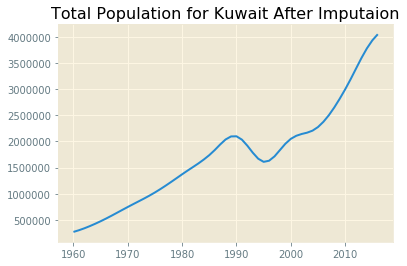

In [32]:
index=df[df['Country Name']==null_total_population[1]]['Total_Population'].index
df.loc[index,'Total_Population']=df[df['Country Name']==null_total_population[1]]['Total_Population'].interpolate(method='cubic')

plt.plot(pd.unique(df['Year']),df[df['Country Name']==null_total_population[1]]['Total_Population'])
plt.title("Total Population for Kuwait After Imputaion")


----------------------------------------------------------<br>
For Eritrea we have missing values in end segment so interpolation doesn't work<br>
We can use population growth rate column to impute the end segment values since there is positive trend

Text(0.5, 1.0, 'Total Population for Eritrea before Imputaion')

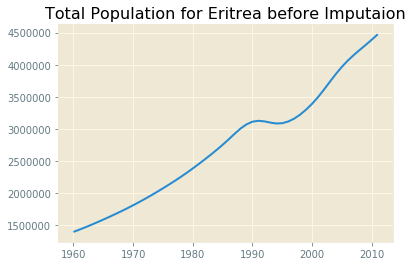

In [33]:
plt.plot(pd.unique(df['Year']),df[df['Country Name']==null_total_population[0]]['Total_Population'])
plt.title("Total Population for Eritrea before Imputaion")

In [34]:
df[['Population_growth_rate(%)']]=df[['Population_growth_rate(%)']].fillna(method='ffill')

Since there is a positive trend in the Popualtion  we are imputing the population growth rate to Imputation.

In [35]:
df['dummy']=df['Total_Population']
while(len(df[df['dummy'].isna()])>0):
    val=np.where((df['dummy'].isna()),
        df['dummy'].shift(periods=1)*(1+(df['Population_growth_rate(%)']/100)),df['dummy'])
    df['dummy']=val
df['Total_Population']=df['dummy']
df.drop('dummy',axis=1,inplace=True)

Text(0.5, 1.0, 'Total Population for Eritrea After Imputaion')

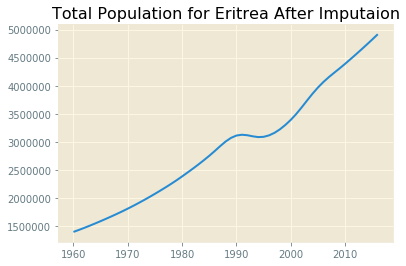

In [36]:
plt.plot(pd.unique(df['Year']),df[df['Country Name']==null_total_population[0]]['Total_Population'])
plt.title("Total Population for Eritrea After Imputaion")

In [37]:
df.isnull().sum()

Region                                          0
IncomeGroup                                     0
Country Name                                    0
Year                                            0
Life_expectancy                                 0
Total_Population                                0
Population_growth_rate(%)                       0
Fertility_rate                                  0
Birth rate, crude (per 1,000 people)            0
Death rate, crude (per 1,000 people)            0
GDP growth (annual %)                        2560
Population ages 0-14 (% of total)            1908
Population ages 0-14, female                 1911
Population ages 15-64 (% of total)           1906
Population ages 15-64, female                1911
Population ages 15-64, male                  1911
Population ages 15-64, total                 1911
Population ages 65 and above (% of total)       5
Population ages 65 and above, female            8
Population, female                           1911


<b>Renaming the column name for convenience</b>

In [38]:
df=df.rename(columns={'Birth rate, crude (per 1,000 people)':'Birth_rate','Death rate, crude (per 1,000 people)':'Death_rate',
                  'GDP growth (annual %)':'GDP_growth'})

In [39]:
df.head()

,Region,IncomeGroup,Country Name,Year,Life_expectancy,Total_Population,Population_growth_rate(%),Fertility_rate,Birth_rate,Death_rate,GDP_growth,Population ages 0-14 (% of total),"Population ages 0-14, female",Population ages 15-64 (% of total),"Population ages 15-64, female","Population ages 15-64, male","Population ages 15-64, total",Population ages 65 and above (% of total),"Population ages 65 and above, female","Population, female","Population, female (% of total)"
0,South Asia,Low income,Afghanistan,1960,32.292,8996351.0,0.0,7.45,51.279,32.219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.798308,115755.0,NaN,NaN
1,South Asia,Low income,Afghanistan,1961,32.742,9166764.0,1.9,7.45,51.373,31.649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.808131,118864.0,NaN,NaN
2,South Asia,Low income,Afghanistan,1962,33.185,9345868.0,2.0,7.45,51.457,31.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.804113,121786.0,NaN,NaN
3,South Asia,Low income,Afghanistan,1963,33.624,9533954.0,2.0,7.45,51.530,30.551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.786171,124431.0,NaN,NaN
4,South Asia,Low income,Afghanistan,1964,34.060,9731361.0,2.1,7.45,51.589,30.022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.754223,126641.0,NaN,NaN


## Feature Engineering :

<b> Converting crude birth rate of factor 1000 to distinct value <b>

In [40]:
val=np.round(df['Total_Population']*df['Birth_rate']/1000)
df.insert(loc=8, column='Total_births', value=val)
df.head()

,Region,IncomeGroup,Country Name,Year,Life_expectancy,Total_Population,Population_growth_rate(%),Fertility_rate,Total_births,Birth_rate,Death_rate,GDP_growth,Population ages 0-14 (% of total),"Population ages 0-14, female",Population ages 15-64 (% of total),"Population ages 15-64, female","Population ages 15-64, male","Population ages 15-64, total",Population ages 65 and above (% of total),"Population ages 65 and above, female","Population, female","Population, female (% of total)"
0,South Asia,Low income,Afghanistan,1960,32.292,8996351.0,0.0,7.45,461324.0,51.279,32.219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.798308,115755.0,NaN,NaN
1,South Asia,Low income,Afghanistan,1961,32.742,9166764.0,1.9,7.45,470924.0,51.373,31.649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.808131,118864.0,NaN,NaN
2,South Asia,Low income,Afghanistan,1962,33.185,9345868.0,2.0,7.45,480910.0,51.457,31.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.804113,121786.0,NaN,NaN
3,South Asia,Low income,Afghanistan,1963,33.624,9533954.0,2.0,7.45,491285.0,51.530,30.551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.786171,124431.0,NaN,NaN
4,South Asia,Low income,Afghanistan,1964,34.060,9731361.0,2.1,7.45,502031.0,51.589,30.022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.754223,126641.0,NaN,NaN


<b> Converting crude Death rate of factor 1000 to distinct value <b>

In [41]:
val=np.round(df['Total_Population']*df['Death_rate']/1000)
df.insert(loc=9, column='Total_deaths', value=val)
df.head()

,Region,IncomeGroup,Country Name,Year,Life_expectancy,Total_Population,Population_growth_rate(%),Fertility_rate,Total_births,Total_deaths,Birth_rate,Death_rate,GDP_growth,Population ages 0-14 (% of total),"Population ages 0-14, female",Population ages 15-64 (% of total),"Population ages 15-64, female","Population ages 15-64, male","Population ages 15-64, total",Population ages 65 and above (% of total),"Population ages 65 and above, female","Population, female","Population, female (% of total)"
0,South Asia,Low income,Afghanistan,1960,32.292,8996351.0,0.0,7.45,461324.0,289853.0,51.279,32.219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.798308,115755.0,NaN,NaN
1,South Asia,Low income,Afghanistan,1961,32.742,9166764.0,1.9,7.45,470924.0,290119.0,51.373,31.649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.808131,118864.0,NaN,NaN
2,South Asia,Low income,Afghanistan,1962,33.185,9345868.0,2.0,7.45,480910.0,290591.0,51.457,31.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.804113,121786.0,NaN,NaN
3,South Asia,Low income,Afghanistan,1963,33.624,9533954.0,2.0,7.45,491285.0,291272.0,51.530,30.551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.786171,124431.0,NaN,NaN
4,South Asia,Low income,Afghanistan,1964,34.060,9731361.0,2.1,7.45,502031.0,292155.0,51.589,30.022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.754223,126641.0,NaN,NaN


<b> creating a new column Net Migration:</b><br><br>
Total_population diff from previous year= Natural_Increase + Net Migration <br><br>
        Natural_increase= total_births - total_deaths<br>
<br>
Net Migration = Total_population diff from previous year - Natural_Increase<br>

In [42]:
Natural_Increase= df['Total_births']-df['Total_deaths']
Total_pop_diff_prev_year=df.groupby(['Country Name'])['Total_Population'].diff().fillna(0)
Net_Migration=Total_pop_diff_prev_year-Natural_Increase
df.insert(loc=10, column='Net_Migration', value=Net_Migration)
df.loc[df['Year'] ==1960, ['Net_Migration']] = 0

In [43]:
df.head()

,Region,IncomeGroup,Country Name,Year,Life_expectancy,Total_Population,Population_growth_rate(%),Fertility_rate,Total_births,Total_deaths,Net_Migration,Birth_rate,Death_rate,GDP_growth,Population ages 0-14 (% of total),"Population ages 0-14, female",Population ages 15-64 (% of total),"Population ages 15-64, female","Population ages 15-64, male","Population ages 15-64, total",Population ages 65 and above (% of total),"Population ages 65 and above, female","Population, female","Population, female (% of total)"
0,South Asia,Low income,Afghanistan,1960,32.292,8996351.0,0.0,7.45,461324.0,289853.0,0.0,51.279,32.219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.798308,115755.0,NaN,NaN
1,South Asia,Low income,Afghanistan,1961,32.742,9166764.0,1.9,7.45,470924.0,290119.0,-10392.0,51.373,31.649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.808131,118864.0,NaN,NaN
2,South Asia,Low income,Afghanistan,1962,33.185,9345868.0,2.0,7.45,480910.0,290591.0,-11215.0,51.457,31.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.804113,121786.0,NaN,NaN
3,South Asia,Low income,Afghanistan,1963,33.624,9533954.0,2.0,7.45,491285.0,291272.0,-11927.0,51.530,30.551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.786171,124431.0,NaN,NaN
4,South Asia,Low income,Afghanistan,1964,34.060,9731361.0,2.1,7.45,502031.0,292155.0,-12469.0,51.589,30.022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.754223,126641.0,NaN,NaN


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10830 entries, 0 to 14990
Data columns (total 24 columns):
Region                                       10830 non-null object
IncomeGroup                                  10830 non-null object
Country Name                                 10830 non-null object
Year                                         10830 non-null int32
Life_expectancy                              10830 non-null float64
Total_Population                             10830 non-null float64
Population_growth_rate(%)                    10830 non-null float64
Fertility_rate                               10830 non-null float64
Total_births                                 10830 non-null float64
Total_deaths                                 10830 non-null float64
Net_Migration                                10830 non-null float64
Birth_rate                                   10830 non-null float64
Death_rate                                   10830 non-null float64
GDP_growth  

## Feature Selection:

<b> Feature Selection for india </b>

In [45]:
columns=['Year','Life_expectancy','Total_Population','Fertility_rate']

In [46]:
df1=df[df['Country Name']=='India'][columns]

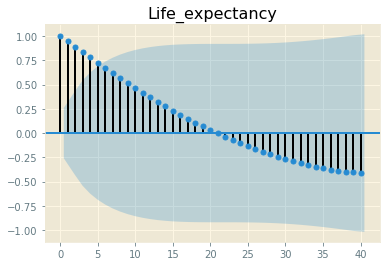

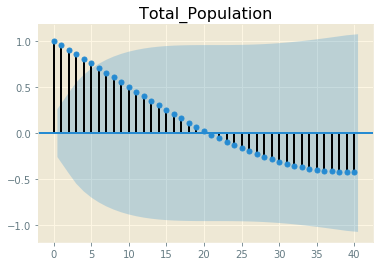

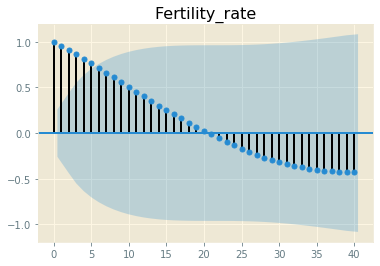

In [47]:
for i in df1.columns[1:]:
    acf = smt.graphics.plot_acf(df1[i], lags=40 , alpha=0.05,title=i)
    acf.show()

Statestic test for auto correlation using dutbin_watson test

In [48]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(df1.iloc[:,1:])

In [49]:
for col,val in zip(df1.columns[1:],out):
    print(col,' : ',round(val,4))

Life_expectancy  :  0.0001
Total_Population  :  0.0003
Fertility_rate  :  0.0002


 All Values are less than 2 so we can say all columns are positive correlated

## VAC- Vector Auto Regression

### Testing Causation using Granger’s Causality Test

<p>
Null Hypothesis      : Variable X does not Cause Varible Y <br>
Alternate HYpothesis : Varibel X causes Variable Y
 </p>

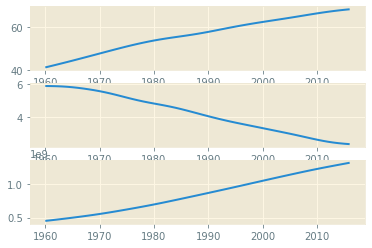

In [50]:
fig, axs = plt.subplots(3)
axs[0].plot(df1['Year'],df1['Life_expectancy'])
axs[1].plot(df1['Year'],df1['Fertility_rate'])
axs[2].plot(df1['Year'],df1['Total_Population'])


In [51]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df2 = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df2.columns:
        for r in df2.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df2.loc[r, c] = min_p_value
    df2.columns = [var + '_x' for var in variables]
    df2.index = [var + '_y' for var in variables]
    return df2

grangers_causation_matrix(df1, variables = df1.columns) 

,Year_x,Life_expectancy_x,Total_Population_x,Fertility_rate_x
Year_y,0.0000,0.0,1.0,0.0
Life_expectancy_y,0.0614,1.0,0.0,0.0
Total_Population_y,0.0000,0.0,1.0,0.0
Fertility_rate_y,0.0000,0.0,0.0,1.0


### Train Test Split

In [52]:
column=['Life_expectancy','Total_Population','Fertility_rate']

In [53]:
X_train=df1[df1['Year']<2016][column]
y_train=df1[df1['Year']<2016]['Year']
X_test=df1[df1['Year']>=2016][column]
y_test=df1[df1['Year']>=2016]['Year']

### Checking whether the columns are stationary or not

Null Hypothesis: Data has unit root. Non Stationary<br>
Alternate Hypothesis: Data does not have unit root. Stationary

In [54]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [55]:
# ADF Test on each column
for name, column in X_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Life_expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6736
 No. Lags Chosen       = 7
 Critical value 1%     = -3.575
 Critical value 5%     = -2.924
 Critical value 10%    = -2.6
 => P-Value = 0.0787. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Total_Population" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8063
 No. Lags Chosen       = 9
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.3773. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Fertility_rate" 
    -----------------------------------------------
 Nu

Stationary means there is a no trend over the years or the mean and median does not change over the years
But the all columns are non stationary except Fertility rate Which means fertiltiy rate is stable throught out the years

### Changing non stationary to stationary

In [56]:
# 1st difference
X_train_differenced = X_train.diff().dropna()

In [57]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Life_expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.5757
 No. Lags Chosen       = 3
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.8764. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Total_Population" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9295
 No. Lags Chosen       = 8
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.3183. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Fertility_rate" 
    -----------------------------------------------
 N

In [58]:
# second Differnce

X_train_differenced = X_train_differenced.diff().dropna()

In [59]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Life_expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0599
 No. Lags Chosen       = 2
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Total_Population" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.1243
 No. Lags Chosen       = 7
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.947. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Fertility_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has u

In [60]:
# Third Difference

X_train_differenced = X_train_differenced.diff().dropna()

In [61]:
# ADF Test on each column of 3rd Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Life_expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.6783
 No. Lags Chosen       = 4
 Critical value 1%     = -3.575
 Critical value 5%     = -2.924
 Critical value 10%    = -2.6
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Total_Population" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.7207
 No. Lags Chosen       = 6
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.0038. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Fertility_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stati

So after the third differnce all columns have become stationary

In [62]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
model = VAR(X_train_differenced)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.7232,-0.5978,0.4852,-0.6775
1,-3.318,-2.816,0.03630,-3.135
2,-4.252,-3.374,0.01438,-3.932
3,-4.592,-3.338,0.01044,-4.135
4,-4.465,-2.835,0.01232,-3.871
5,-4.595,-2.589,0.01151,-3.865
6,-4.868,-2.485,0.009676,-4.000
7,-5.298,-2.539,0.007292,-4.293
8,-5.254,-2.119,0.009453,-4.113
9,-5.497,-1.986,0.01018,-4.219


Lag 3 is best suited for VAR because there is fluctuation in those lags

In [63]:
model = VAR(X_train_differenced)
results = model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Aug, 2020
Time:                     15:47:50
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -106.132
Nobs:                     39.0000    HQIC:                  -109.661
Log likelihood:           2139.87    FPE:               -3.79997e-48
AIC:                     -111.635    Det(Omega_mle):    -4.08820e-49
--------------------------------------------------------------------
Results for equation Life_expectancy
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.004949         0.002955            1.675           0.094
L1.Life_expectancy          -0.085820              NAN              NAN             NAN
L1.Total_Population   

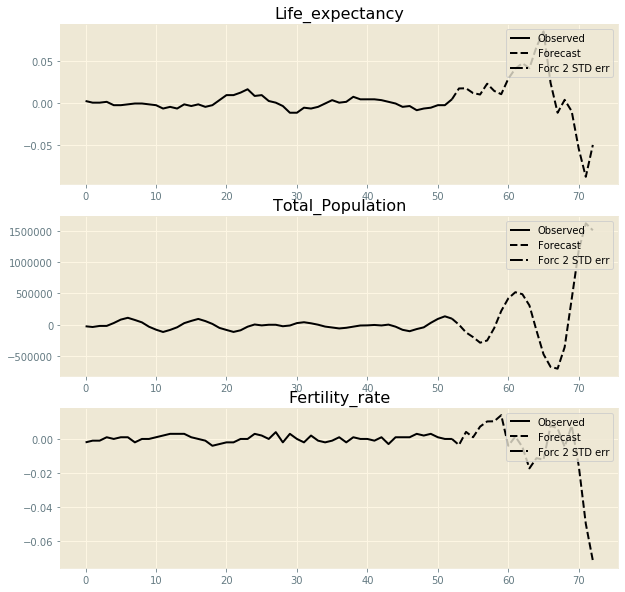

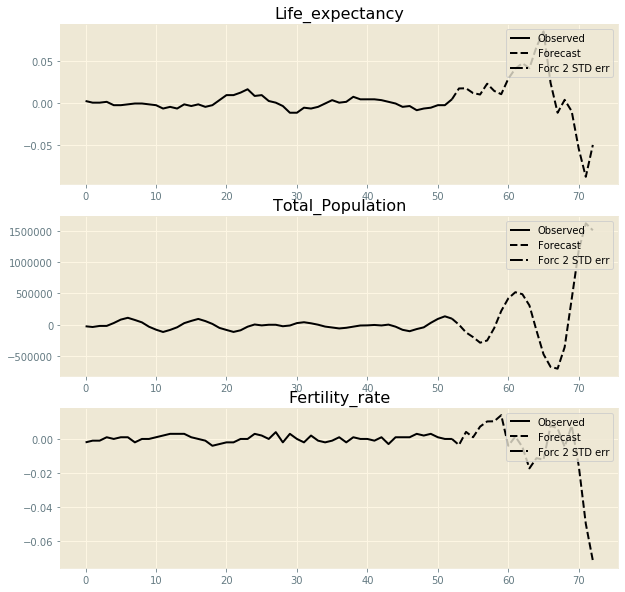

In [64]:
results.plot_forecast(20)

In [65]:
# forecasting
nobs=50
pred = results.forecast(results.y, steps=nobs)
df_forecast = pd.DataFrame(pred, index=X_train.index[-nobs:], columns=X_train.columns + '_1d')
df_forecast.tail()
# inverting transformation
def invert_transformation(df_train, df_forecast, second_diff=True):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
# show inverted results in a dataframe
df_results = invert_transformation(X_train, df_forecast, second_diff=True)        
# df_results.loc[:, ['Total_Population','Life_expectancy','Fertility_rate']]

In [66]:
Final_forecast=df_results.copy()

In [67]:
val=[i for i in range(2016,2016+len(Final_forecast))]

Final_forecast.insert(loc=0, column='Year', value=val)

In [68]:
Final_forecast.drop(['Life_expectancy_1d','Total_Population_1d','Fertility_rate_1d'],axis=1,inplace=True)

In [69]:
Final_forecast.head(10)

,Year,Life_expectancy_forecast,Total_Population_forecast,Fertility_rate_forecast
6162,2016,68.599939,1.324249e+09,2.316460
6163,2017,68.915022,1.339320e+09,2.285056
6164,2018,69.241552,1.354192e+09,2.254644
6165,2019,69.577795,1.368775e+09,2.231472
6166,2020,69.936651,1.383105e+09,2.218568
6167,2021,70.309528,1.397381e+09,2.216028
6168,2022,70.692514,1.411877e+09,2.227426
6169,2023,71.104053,1.426794e+09,2.234825
6170,2024,71.556256,1.442232e+09,2.243638
6171,2025,72.055448,1.458159e+09,2.247750


## Actual vs Forecast for year 2016 in india

In [70]:
X_test.head()

,Life_expectancy,Total_Population,Fertility_rate
6212,68.56,1.324171e+09,2.326


In [71]:
print('The percentage of differnce between Actual and Forecasted result for India:')
print("Life_expectancy  :",np.round((Final_forecast.iloc[0,1]-X_test.iloc[0,0])/X_test.iloc[0,0]*100,3),'%')
print("Total_Population :",np.round((Final_forecast.iloc[0,2]-X_test.iloc[0,1])/X_test.iloc[0,1]*100,3),'%')
print("Fertility_rate   :",np.round((Final_forecast.iloc[0,3]-X_test.iloc[0,2])/X_test.iloc[0,2]*100,3),'%')

The percentage of differnce between Actual and Forecasted result for India:
Life_expectancy  : 0.058 %
Total_Population : 0.006 %
Fertility_rate   : -0.41 %


In [72]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE 
    return({'mape':mape,'rmse':rmse})

In [73]:
print(forecast_accuracy(Final_forecast.iloc[0,2],X_test.iloc[0,1]))

{'mape': 0.005861661072344792, 'rmse': 77618.43678855896}


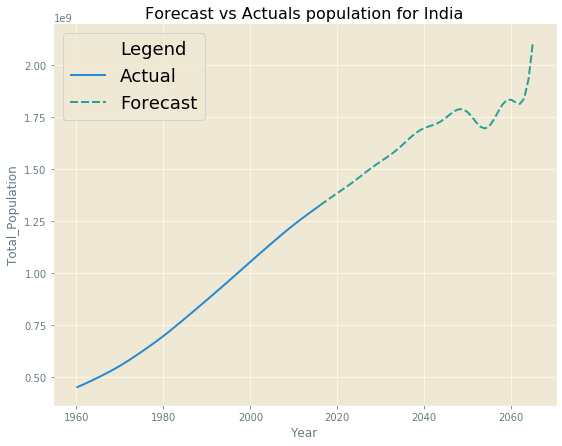

In [74]:
df_final_actual=df[df['Country Name']=='India'][['Year','Total_Population']]
df_final_actual['Legend']='Actual'
df_final_forecast=pd.DataFrame(Final_forecast[['Year','Total_Population_forecast']])
df_final_forecast=df_final_forecast.rename(columns={'Total_Population_forecast':'Total_Population'})
df_final_forecast['Legend']='Forecast'
df_final=pd.concat([df_final_actual,df_final_forecast],ignore_index=True)


plt.figure(figsize=(9,7))
sns.lineplot(x='Year',y='Total_Population',data=df_final,hue='Legend',style='Legend',dashes=True)
plt.title('Forecast vs Actuals population for India')
plt.legend(loc='upper left', fontsize=18,title=None)
plt.show()

## Population Prediction for Israel

In [75]:
df2=df[df['Country Name']=='Israel'][columns]
df2.head()
column=['Life_expectancy','Total_Population','Fertility_rate']

In [76]:
X_train=df2[df2['Year']<2016][column]
y_train=df2[df2['Year']<2016]['Year']
X_test=df2[df2['Year']>=2016][column]
y_test=df2[df2['Year']>=2016]['Year']

## Stationarity Test

In [77]:
# ADF Test on each column
for name, column in X_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Life_expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.7464
 No. Lags Chosen       = 3
 Critical value 1%     = -3.563
 Critical value 5%     = -2.919
 Critical value 10%    = -2.597
 => P-Value = 0.9907. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Total_Population" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 2.3242
 No. Lags Chosen       = 1
 Critical value 1%     = -3.558
 Critical value 5%     = -2.917
 Critical value 10%    = -2.596
 => P-Value = 0.999. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Fertility_rate" 
    -----------------------------------------------
 Nul

### Changing Non stationary to stationary

In [78]:
# 1st difference
X_train_differenced = X_train.diff().dropna()

In [79]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Life_expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.3862
 No. Lags Chosen       = 3
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.0114. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Total_Population" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.174
 No. Lags Chosen       = 0
 Critical value 1%     = -3.558
 Critical value 5%     = -2.917
 Critical value 10%    = -2.596
 => P-Value = 0.0215. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Fertility_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stati

In [80]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
model = VAR(X_train_differenced)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,13.51,13.63,7.371e+05,13.56
1,12.76,13.25*,3.473e+05,12.94
2,12.42,13.28,2.509e+05*,12.74*
3,12.54,13.77,2.879e+05,13.00
4,12.40,14.00,2.580e+05,12.99
5,12.52,14.49,3.067e+05,13.25
6,12.72,15.06,4.078e+05,13.58
7,12.84,15.54,5.197e+05,13.84
8,13.03,16.10,7.522e+05,14.16
9,13.24,16.68,1.194e+06,14.50


In [85]:
model = VAR(X_train_differenced)
results = model.fit(maxlags=12, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Aug, 2020
Time:                     16:05:22
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    16.3342
Nobs:                     43.0000    HQIC:                   13.4644
Log likelihood:          -325.481    FPE:                1.78659e+06
AIC:                      11.7878    Det(Omega_mle):         277434.
--------------------------------------------------------------------
Results for equation Life_expectancy
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.168161         1.756712            0.096           0.924
L1.Life_expectancy          -0.742911         0.392542           -1.893           0.058
L1.Total_Population   

In [86]:
# forecasting
nobs=50
pred = results.forecast(results.y, steps=nobs)
df_forecast = pd.DataFrame(pred, index=X_train.index[-nobs:], columns=X_train.columns + '_1d')
df_forecast.tail()
# inverting transformation
def invert_transformation(df_train, df_forecast, second_diff=True):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
# show inverted results in a dataframe
df_results = invert_transformation(X_train, df_forecast, second_diff=True)        
# df_results.loc[:, ['Total_Population','Life_expectancy','Fertility_rate']]

In [87]:
 
Final_forecast=df_results.copy()
 
val=[i for i in range(2016,2016+len(Final_forecast))]

Final_forecast.insert(loc=0, column='Year', value=val)

Final_forecast.drop(['Life_expectancy_1d','Total_Population_1d','Fertility_rate_1d'],axis=1,inplace=True)

Final_forecast.head()

,Year,Life_expectancy_forecast,Total_Population_forecast,Fertility_rate_forecast
6504,2016,82.813874,8.687761e+06,3.232106
6505,2017,83.108702,9.226284e+06,3.353445
6506,2018,84.425682,1.003172e+07,3.534088
6507,2019,85.866125,1.110977e+07,3.672966
6508,2020,88.238532,1.244191e+07,3.996066


In [88]:
print('The percentage of differnce between Actual and Forecasted result for Israel:')
# print("Life_expectancy  :",np.round((Final_forecast.iloc[0,1]-X_test.iloc[0,0])/X_test.iloc[0,0]*100,3),'%')
print("Total_Population :",np.round((Final_forecast.iloc[0,2]-X_test.iloc[0,1])/X_test.iloc[0,1]*100,3),'%')
# print("Fertility_rate   :",np.round((Final_forecast.iloc[0,3]-X_test.iloc[0,2])/X_test.iloc[0,2]*100,3),'%')

The percentage of differnce between Actual and Forecasted result for Israel:
Total_Population : 1.659 %


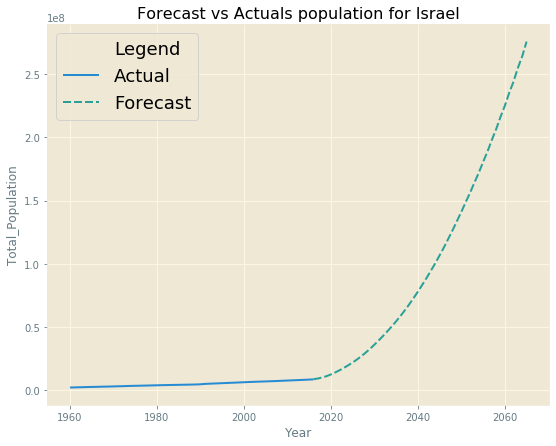

In [89]:
df_final_actual=df[df['Country Name']=='Israel'][['Year','Total_Population']]
df_final_actual['Legend']='Actual'
df_final_forecast=pd.DataFrame(Final_forecast[['Year','Total_Population_forecast']])
df_final_forecast=df_final_forecast.rename(columns={'Total_Population_forecast':'Total_Population'})
df_final_forecast['Legend']='Forecast'
df_final=pd.concat([df_final_actual,df_final_forecast],ignore_index=True)


plt.figure(figsize=(9,7))
sns.lineplot(x='Year',y='Total_Population',data=df_final,hue='Legend',style='Legend',dashes=True)
plt.title('Forecast vs Actuals population for Israel')
plt.legend(loc='upper left', fontsize=18,title=None)
plt.show()

## Population Prediction for Tanzania

In [90]:
df3=df[df['Country Name']=='Tanzania'][columns]
df3.head()
column=['Life_expectancy','Total_Population','Fertility_rate']

In [91]:
X_train=df3[df3['Year']<2016][column]
y_train=df3[df3['Year']<2016]['Year']
X_test=df3[df3['Year']>=2016][column]
y_test=df3[df3['Year']>=2016]['Year']

### Stationarity Test

In [92]:
# ADF Test on each column
for name, column in X_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Life_expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.8873
 No. Lags Chosen       = 4
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.9929. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Total_Population" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 3.4286
 No. Lags Chosen       = 11
 Critical value 1%     = -3.589
 Critical value 5%     = -2.93
 Critical value 10%    = -2.603
 => P-Value = 1.0. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Fertility_rate" 
    -----------------------------------------------
 Null H

<b> Changing Non stationary to Stationary

In [93]:
# 1st difference
X_train_differenced = X_train.diff().dropna()

In [94]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Life_expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.3121
 No. Lags Chosen       = 3
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.1681. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Total_Population" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 2.1211
 No. Lags Chosen       = 11
 Critical value 1%     = -3.593
 Critical value 5%     = -2.932
 Critical value 10%    = -2.604
 => P-Value = 0.9988. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Fertility_rate" 
    -----------------------------------------------
 N

In [95]:
# second Differnce

X_train_differenced = X_train_differenced.diff().dropna()

In [96]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Life_expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8416
 No. Lags Chosen       = 2
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.36. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Total_Population" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7852
 No. Lags Chosen       = 11
 Critical value 1%     = -3.597
 Critical value 5%     = -2.933
 Critical value 10%    = -2.605
 => P-Value = 0.3878. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Fertility_rate" 
    -----------------------------------------------
 Nu

In [97]:
# third Differnce

X_train_differenced = X_train_differenced.diff().dropna()

In [98]:
# ADF Test on each column of 3rd Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Life_expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.4944
 No. Lags Chosen       = 1
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.0081. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Total_Population" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.4427
 No. Lags Chosen       = 11
 Critical value 1%     = -3.601
 Critical value 5%     = -2.935
 Critical value 10%    = -2.606
 => P-Value = 0.0096. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Fertility_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Sta

In [99]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
model = VAR(X_train_differenced)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-2.384,-2.258,0.09221,-2.338
1,-4.492,-3.990,0.01122,-4.309
2,-5.617,-4.740,0.003671,-5.298
3,-5.562,-4.308,0.003958,-5.105
4,-5.503,-3.873,0.004362,-4.909
5,-6.112,-4.106,0.002526,-5.382
6,-6.690,-4.308,0.001564,-5.823
7,-8.386,-5.628,0.0003323,-7.382
8,-8.810,-5.676,0.0002699,-7.669
9,-9.235,-5.724,0.0002424,-7.956


In [100]:
model = VAR(X_train_differenced)
results = model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Aug, 2020
Time:                     16:05:33
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -116.045
Nobs:                     39.0000    HQIC:                  -119.573
Log likelihood:           2333.15    FPE:               -1.88348e-52
AIC:                     -121.547    Det(Omega_mle):    -2.02635e-53
--------------------------------------------------------------------
Results for equation Life_expectancy
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.002284              NAN              NAN             NAN
L1.Life_expectancy           0.381389              NAN              NAN             NAN
L1.Total_Population   

In [101]:
# forecasting
nobs=50
pred = results.forecast(results.y, steps=nobs)
df_forecast = pd.DataFrame(pred, index=X_train.index[-nobs:], columns=X_train.columns + '_1d')
df_forecast.tail()
# inverting transformation
def invert_transformation(df_train, df_forecast, second_diff=True):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
# show inverted results in a dataframe
df_results = invert_transformation(X_train, df_forecast, second_diff=True)        
# df_results.loc[:, ['Total_Population','Life_expectancy','Fertility_rate']]

In [102]:
 
Final_forecast=df_results.copy()
 
val=[i for i in range(2016,2016+len(Final_forecast))]

Final_forecast.insert(loc=0, column='Year', value=val)

Final_forecast.drop(['Life_expectancy_1d','Total_Population_1d','Fertility_rate_1d'],axis=1,inplace=True)

Final_forecast.head()

,Year,Life_expectancy_forecast,Total_Population_forecast,Fertility_rate_forecast
13401,2016,65.738418,5.553848e+07,5.014943
13402,2017,66.543480,5.722112e+07,4.948745
13403,2018,67.366963,5.892559e+07,4.882782
13404,2019,68.176695,6.063507e+07,4.810982
13405,2020,68.994732,6.234399e+07,4.733166


In [103]:
print('The percentage of differnce between Actual and Forecasted result for Tanzania:')
# print("Life_expectancy  :",np.round((Final_forecast.iloc[0,1]-X_test.iloc[0,0])/X_test.iloc[0,0]*100,3),'%')
print("Total_Population :",np.round((Final_forecast.iloc[0,2]-X_test.iloc[0,1])/X_test.iloc[0,1]*100,3),'%')
# print("Fertility_rate   :",np.round((Final_forecast.iloc[0,3]-X_test.iloc[0,2])/X_test.iloc[0,2]*100,3),'%')

The percentage of differnce between Actual and Forecasted result for Tanzania:
Total_Population : -0.061 %


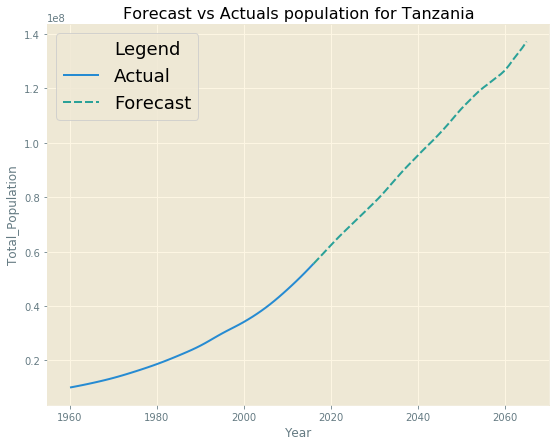

In [104]:
df_final_actual=df[df['Country Name']=='Tanzania'][['Year','Total_Population']]
df_final_actual['Legend']='Actual'
df_final_forecast=pd.DataFrame(Final_forecast[['Year','Total_Population_forecast']])
df_final_forecast=df_final_forecast.rename(columns={'Total_Population_forecast':'Total_Population'})
df_final_forecast['Legend']='Forecast'
df_final=pd.concat([df_final_actual,df_final_forecast],ignore_index=True)


plt.figure(figsize=(9,7))
sns.lineplot(x='Year',y='Total_Population',data=df_final,hue='Legend',style='Legend',dashes=True)
plt.title('Forecast vs Actuals population for Tanzania')
plt.legend(loc='upper left', fontsize=18,title=None)
plt.show()

<b>

<b>

<b>

#                       ARIMA Model

In [105]:
data=df[df['Country Name']=='India'][['Year','Total_Population']].reset_index(drop=True)
data=data.set_index('Year')
train=data.iloc[:-1,:]
test=data.iloc[-1:,:]

## Population Prediction for India

### Checking Stationarity and Finding the value for hyperparameter d

Number of differencing required for changing non staionarity to stationary

In [106]:
from pmdarima.arima.utils import ndiffs

## Adf Test
print('ADF: ',ndiffs(train['Total_Population'], test='adf'))

# PP test:
print('PP',ndiffs(train['Total_Population'], test='pp'))

# KPSS test
print('KPSS',ndiffs(train['Total_Population'], test='kpss'))

ADF:  0
PP 2
KPSS 2


So the number of differencing need is d=2

### Finding the Hyperparameter value P ( Number of lags)

In [107]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train['Total_Population'], start_p=1, start_q=1,
                      test='pp',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=2026.240, BIC=2034.196, Time=1.249 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1503.926, BIC=1507.904, Time=0.027 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=2575.066, BIC=2581.033, Time=0.117 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1505.490, BIC=1511.456, Time=0.053 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1511.512, BIC=1513.501, Time=0.012 seconds
Total fit time: 1.476 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -749.963
Date:                Fri, 14 Aug 2020   AIC                           1503.926
Time:                        16:05:44   BIC                           1507.904
Sample:                             0   HQIC                          1

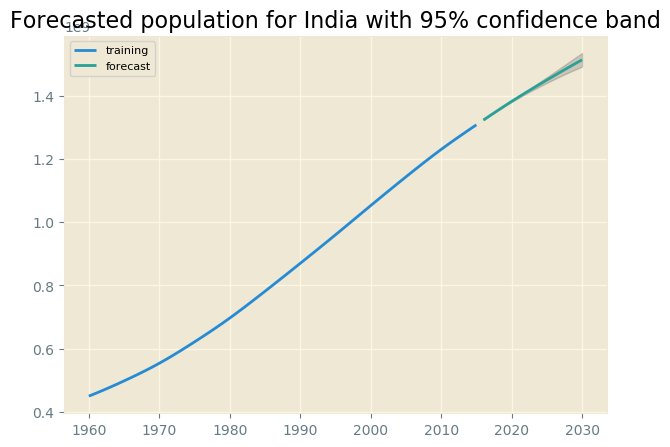

In [108]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf
ind=[i for i in range(2016,2031)]

# Make as pandas series
fc_series = pd.Series(fc, index=ind)
lower_series = pd.Series(conf[:, 0], index=ind)
upper_series = pd.Series(conf[:, 1], index=ind)

# Plot
plt.figure(figsize=(7,5), dpi=100)
plt.plot(train, label='training')
# plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecasted population for India with 95% confidence band')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [109]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                              
===============================================================================
Dep. Variable:     D2.Total_Population   No. Observations:                   54
Model:                  ARIMA(3, 2, 1)   Log Likelihood                -615.627
Method:                        css-mle   S.D. of innovations          19995.936
Date:                 Fri, 14 Aug 2020   AIC                           1243.254
Time:                         16:05:46   BIC                           1255.187
Sample:                              2   HQIC                          1247.856
                                                                               
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1.145e+05    2.3e+05      0.497      0.619   -3.37e+05    5.66e+05
ar.L1.D2.Total_Population     2.5034      0.084     29.806      0.000       2.339       2.668
ar.L2.D2.Total_Population    -2.3574      0.154    -15.310      0.000      -2.659      -2.056
ar.L3.D2.Total_Population     0.8484      0.079     10.715      0.000       0.693       1.004
ma.L1.D2.Total_Population    -0.1883      0.145     -1.298      0.194      -0.473       0.096
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0164           -0.0000j            1.0164           -0.0000
AR.2            0.8811           -0.6191j            1.0769           -0.0975
AR.3            0.8811           +0.6191j            1.0769            0.0975
MA.1            5.3100           +0.0000j            5.3100            0.0000
-----------------------------------------------------------------------------
"""

In [110]:
print('The percentage of differnce between Actual and Forecasted result for India:')
val=np.round((fc_series.iloc[0]-test.iloc[0])/test.iloc[0]*100,3)
print("Total_Population :",val.loc['Total_Population'],'%')

The percentage of differnce between Actual and Forecasted result for India:
Total_Population : 0.001 %


In [111]:
np.round(fc_series.iloc[0])

1324184572.0

In [112]:
print(forecast_accuracy(fc_series.iloc[0],test.iloc[0]))

{'mape': 0.0009982330140902167, 'rmse': 13218.315618753433}


## Population Prediction for Israel

In [113]:
data=df[df['Country Name']=='Israel'][['Year','Total_Population']].reset_index(drop=True)
data=data.set_index('Year')
train=data.iloc[:-1,:]
test=data.iloc[-1:,:]

In [114]:
from pmdarima.arima.utils import ndiffs

## Adf Test
print('ADF: ',ndiffs(train['Total_Population'], test='adf'))

# PP test:
print('PP',ndiffs(train['Total_Population'], test='pp'))

# KPSS test
print('KPSS',ndiffs(train['Total_Population'], test='kpss'))

ADF:  2
PP 1
KPSS 2


In [115]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train['Total_Population'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1284.763, BIC=1292.719, Time=0.237 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1282.472, BIC=1286.450, Time=0.020 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1282.940, BIC=1288.907, Time=0.087 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1282.983, BIC=1288.950, Time=0.115 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1280.652, BIC=1282.641, Time=0.029 seconds
Total fit time: 0.510 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -639.326
Date:                Fri, 14 Aug 2020   AIC                           1280.652
Time:                        16:05:48   BIC                           1282.641
Sample:                             0   HQIC                          1

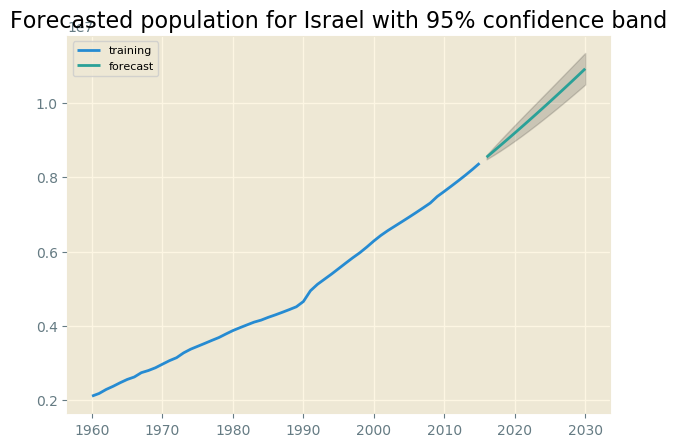

In [116]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf
ind=[i for i in range(2016,2031)]

# Make as pandas series
fc_series = pd.Series(fc, index=ind)
lower_series = pd.Series(conf[:, 0], index=ind)
upper_series = pd.Series(conf[:, 1], index=ind)

# Plot
plt.figure(figsize=(7,5), dpi=100)
plt.plot(train, label='training')
# plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecasted population for Israel with 95% confidence band')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [117]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                              
===============================================================================
Dep. Variable:     D2.Total_Population   No. Observations:                   54
Model:                  ARIMA(1, 2, 1)   Log Likelihood                -632.869
Method:                        css-mle   S.D. of innovations          28967.175
Date:                 Fri, 14 Aug 2020   AIC                           1273.738
Time:                         16:05:48   BIC                           1281.694
Sample:                              2   HQIC                          1276.806
                                                                               
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1576.6138    478.322      3.296      0.001     639.120    2514.107
ar.L1.D2.Total_Population     0.5138      0.120      4.292      0.000       0.279       0.748
ma.L1.D2.Total_Population    -1.0000      0.053    -18.752      0.000      -1.105      -0.895
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9464           +0.0000j            1.9464            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [118]:
print('The percentage of differnce between Actual and Forecasted result for Israel:')
val=np.round((fc_series.iloc[0]-test.iloc[0])/test.iloc[0]*100,3)
print("Total_Population :",val.loc['Total_Population'],'%')

The percentage of differnce between Actual and Forecasted result for Israel:
Total_Population : -0.045 %


In [119]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    accuracy = 100-np.mean(np.abs(forecast - actual)/np.abs(actual))
    return round(accuracy,5)

print("Accuracy level:",forecast_accuracy(fc_series.iloc[0], test.iloc[0]))

Accuracy level: 99.99955


## Population Prediction for Tanzania

In [120]:
data=df[df['Country Name']=='Tanzania'][['Year','Total_Population']].reset_index(drop=True)
data=data.set_index('Year')
train=data.iloc[:-1,:]
test=data.iloc[-1:,:]

In [121]:
from pmdarima.arima.utils import ndiffs

## Adf Test
print('ADF: ',ndiffs(train['Total_Population'], test='adf'))

# PP test:
print('PP',ndiffs(train['Total_Population'], test='pp'))

# KPSS test
print('KPSS',ndiffs(train['Total_Population'], test='kpss'))

ADF:  2
PP 2
KPSS 2


In [122]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train['Total_Population'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=3098.625, BIC=3106.581, Time=0.323 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1242.462, BIC=1246.440, Time=0.013 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1677.470, BIC=1683.437, Time=0.087 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1244.127, BIC=1250.094, Time=0.114 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1282.159, BIC=1284.148, Time=0.012 seconds
Total fit time: 0.570 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -619.231
Date:                Fri, 14 Aug 2020   AIC                           1242.462
Time:                        16:05:50   BIC                           1246.440
Sample:                             0   HQIC                          1

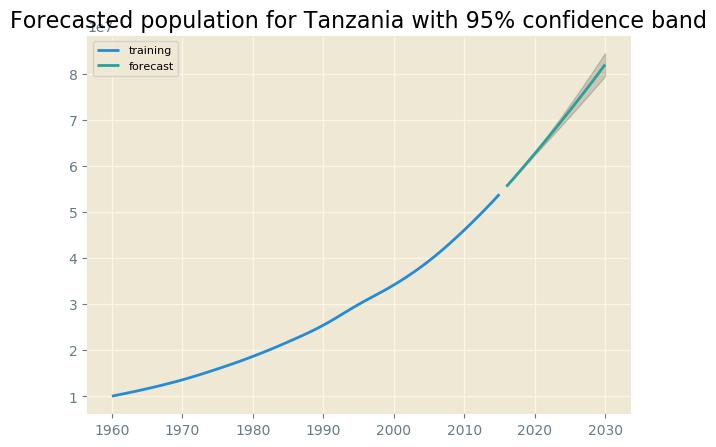

In [123]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(2, 2, 3))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf
ind=[i for i in range(2016,2031)]

# Make as pandas series
fc_series = pd.Series(fc, index=ind)
lower_series = pd.Series(conf[:, 0], index=ind)
upper_series = pd.Series(conf[:, 1], index=ind)

# Plot
plt.figure(figsize=(7,5), dpi=100)
plt.plot(train, label='training')
# plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecasted population for Tanzania with 95% confidence band')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [124]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                              
===============================================================================
Dep. Variable:     D2.Total_Population   No. Observations:                   54
Model:                  ARIMA(2, 2, 3)   Log Likelihood                -519.344
Method:                        css-mle   S.D. of innovations           3243.282
Date:                 Fri, 14 Aug 2020   AIC                           1052.687
Time:                         16:05:51   BIC                           1066.610
Sample:                              2   HQIC                          1058.057
                                                                               
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2.495e+04   5572.596      4.478      0.000     1.4e+04    3.59e+04
ar.L1.D2.Total_Population     1.5019      0.150      9.989      0.000       1.207       1.797
ar.L2.D2.Total_Population    -0.6720      0.132     -5.094      0.000      -0.931      -0.413
ma.L1.D2.Total_Population     1.1955      0.186      6.420      0.000       0.830       1.560
ma.L2.D2.Total_Population     0.3893      0.287      1.357      0.175      -0.173       0.952
ma.L3.D2.Total_Population    -0.3861      0.179     -2.159      0.031      -0.737      -0.036
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1174           -0.4893j            1.2198           -0.0657
AR.2            1.1174           +0.4893j            1.2198            0.0657
MA.1           -0.7908           -0.6121j            1.0000           -0.3952
MA.2           -0.7908           +0.6121j            1.0000            0.3952
MA.3            2.5897           -0.0000j            2.5897           -0.0000
-----------------------------------------------------------------------------
"""

In [125]:
print('The percentage of differnce between Actual and Forecasted result for Tanzania:')
val=np.round((fc_series.iloc[0]-test.iloc[0])/test.iloc[0]*100,3)
print("Total_Population :",val.loc['Total_Population'],'%')

The percentage of differnce between Actual and Forecasted result for Tanzania:
Total_Population : -0.004 %


In [126]:
# Accuracy metrics

print("Accuracy level:",forecast_accuracy(fc_series.iloc[0], test.iloc[0]))

Accuracy level: 99.99996


<br><br>
# Exponential Smoothing

<b>Simple Exponential Smoothing</b>
>When to use?<br>
   Few data points, Irregular data, No seasonality or trend.<br><br>
   
   
<b>Holt’s Linear Smoothing</b>
>When to use?<br>
Trend in data, No seasonality.<br><br>


<b>Holt’s Damped Trend</b>
>When to use?<br>
Data has a trend. Use the multiplicative version, unless the data has been logged before. In this case, use the additive version

## Population Prediction for India

In [127]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt


data=df[df['Country Name']=='India'][['Year','Total_Population']].reset_index(drop=True)
data=data.set_index('Year')
train=data.iloc[:-1,:]
test=data.iloc[-1:,:]

In [128]:
data.head()

,Total_Population
Year,
1960,449480608.0
1961,458494963.0
1962,467852537.0
1963,477527970.0
1964,487484535.0


In [129]:
model = Holt(np.asarray(train['Total_Population']))


fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(15)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(15)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(15)


In [130]:
fit1.summary()

Dep. Variable:,endog,No. Observations:,56
Model:,Holt,SSE,5597173756236353.000
Optimized:,True,AIC,1813.198
Trend:,Additive,BIC,1821.300
Seasonal:,None,AICC,1814.913
Seasonal Periods:,None,Date:,"Fri, 14 Aug 2020"
Box-Cox:,False,Time:,16:05:52
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3000000,alpha,False
smoothing_slope,0.0500000,beta,False


In [131]:
fit2.summary()

Dep. Variable:,endog,No. Observations:,56
Model:,Holt,SSE,4363801488520.540
Optimized:,True,AIC,1412.425
Trend:,Additive,BIC,1420.526
Seasonal:,None,AICC,1414.139
Seasonal Periods:,None,Date:,"Fri, 14 Aug 2020"
Box-Cox:,False,Time:,16:05:52
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_slope,1.0000000,beta,True


In [132]:
fit3.summary()

Dep. Variable:,endog,No. Observations:,56
Model:,Holt,SSE,880423483826673.375
Optimized:,True,AIC,1709.620
Trend:,Additive,BIC,1717.721
Seasonal:,None,AICC,1711.334
Seasonal Periods:,None,Date:,"Fri, 14 Aug 2020"
Box-Cox:,False,Time:,16:05:53
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3000000,alpha,False
smoothing_slope,0.2000000,beta,False


<b> Fit2 is better because it has lowest AIC score

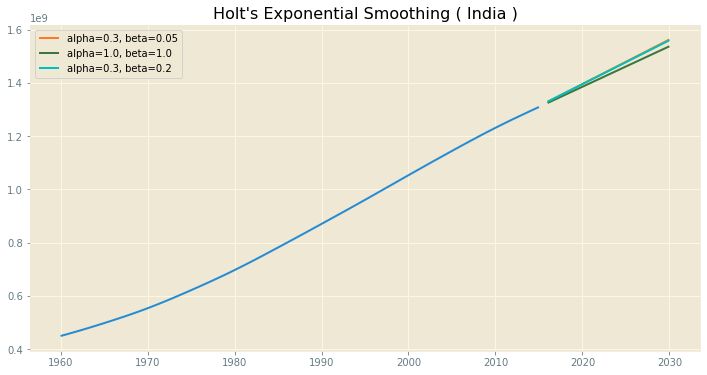

In [133]:

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ind=[i for i in range(2016,2031)]
# ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
#     ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(ind, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing ( India )")
plt.legend();

In [134]:
print('The percentage of differnce between Actual and Forecasted result for India:')
f1=np.round((pred1[0]-test.iloc[0])/test.iloc[0]*100,3)
f2=np.round((pred2[0]-test.iloc[0])/test.iloc[0]*100,3)
f3=np.round((pred3[0]-test.iloc[0])/test.iloc[0]*100,3)
print("Total_Population for model with alpha= 0.3 and beta=0.05: ",f1.loc['Total_Population'],'%')
print("Total_Population for model with alpha= 0.9 and beta=0.57: ",f2.loc['Total_Population'],'%')
print("Total_Population for model with alpha= 0.3 and beta=0.2 : ",f3.loc['Total_Population'],'%')

The percentage of differnce between Actual and Forecasted result for India:
Total_Population for model with alpha= 0.3 and beta=0.05:  0.304 %
Total_Population for model with alpha= 0.9 and beta=0.57:  0.006 %
Total_Population for model with alpha= 0.3 and beta=0.2 :  0.376 %


In [135]:
print(forecast_accuracy(pred2[0],test.iloc[0]))

99.99994


## Population Prediction for Israel

In [136]:
data=df[df['Country Name']=='Israel'][['Year','Total_Population']].reset_index(drop=True)
data=data.set_index('Year')
train=data.iloc[:-1,:]
test=data.iloc[-1:,:]

In [137]:
model = Holt(np.asarray(train['Total_Population']))


fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(15)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(15)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(15)


In [138]:
fit1.summary()

Dep. Variable:,endog,No. Observations:,56
Model:,Holt,SSE,475173327872.239
Optimized:,True,AIC,1288.249
Trend:,Additive,BIC,1296.351
Seasonal:,None,AICC,1289.964
Seasonal Periods:,None,Date:,"Fri, 14 Aug 2020"
Box-Cox:,False,Time:,16:05:59
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3000000,alpha,False
smoothing_slope,0.0500000,beta,False


In [139]:
fit2.summary()

Dep. Variable:,endog,No. Observations:,56
Model:,Holt,SSE,56315066221.553
Optimized:,True,AIC,1168.817
Trend:,Additive,BIC,1176.918
Seasonal:,None,AICC,1170.531
Seasonal Periods:,None,Date:,"Fri, 14 Aug 2020"
Box-Cox:,False,Time:,16:05:59
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_slope,0.5935969,beta,True


In [140]:
fit3.summary()

Dep. Variable:,endog,No. Observations:,56
Model:,Holt,SSE,294446221590.492
Optimized:,True,AIC,1261.449
Trend:,Additive,BIC,1269.550
Seasonal:,None,AICC,1263.163
Seasonal Periods:,None,Date:,"Fri, 14 Aug 2020"
Box-Cox:,False,Time:,16:06:00
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3000000,alpha,False
smoothing_slope,0.2000000,beta,False


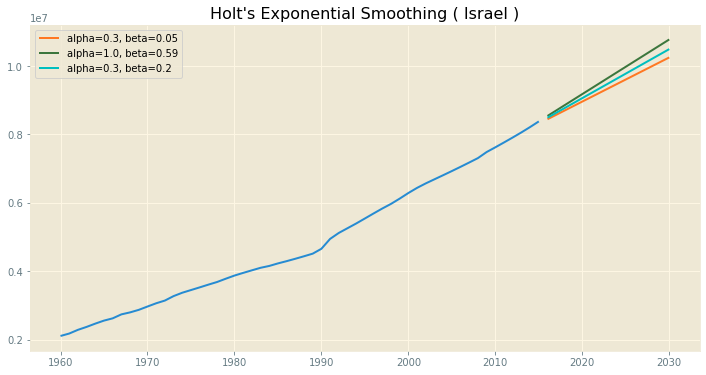

In [141]:

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ind=[i for i in range(2016,2031)]
# ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
#     ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(ind, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing ( Israel )")
plt.legend();

In [142]:
print('The percentage of differnce between Actual and Forecasted result for Israel:')
f1=np.round((pred1[0]-test.iloc[0])/test.iloc[0]*100,3)
f2=np.round((pred2[0]-test.iloc[0])/test.iloc[0]*100,3)
f3=np.round((pred3[0]-test.iloc[0])/test.iloc[0]*100,3)
print("Total_Population for model with alpha= 0.3 and beta=0.05: ",f1.loc['Total_Population'],'%')
print("Total_Population for model with alpha= 0.9 and beta=0.57: ",f2.loc['Total_Population'],'%')
print("Total_Population for model with alpha= 0.3 and beta=0.2 : ",f3.loc['Total_Population'],'%')

The percentage of differnce between Actual and Forecasted result for Israel:
Total_Population for model with alpha= 0.3 and beta=0.05:  -1.193 %
Total_Population for model with alpha= 0.9 and beta=0.57:  -0.074 %
Total_Population for model with alpha= 0.3 and beta=0.2 :  -0.68 %


In [143]:
print(forecast_accuracy(pred2[0],test.iloc[0]))

99.99926


## Population Prediction for Tanzania

In [144]:
data=df[df['Country Name']=='Tanzania'][['Year','Total_Population']].reset_index(drop=True)
data=data.set_index('Year')
train=data.iloc[:-1,:]
test=data.iloc[-1:,:]

In [145]:
model = Holt(np.asarray(train['Total_Population']))


fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(15)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(15)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(15)


In [146]:
fit1.summary()

Dep. Variable:,endog,No. Observations:,56
Model:,Holt,SSE,49731849792541.586
Optimized:,True,AIC,1548.690
Trend:,Additive,BIC,1556.791
Seasonal:,None,AICC,1550.404
Seasonal Periods:,None,Date:,"Fri, 14 Aug 2020"
Box-Cox:,False,Time:,16:06:03
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3000000,alpha,False
smoothing_slope,0.0500000,beta,False


In [147]:
fit2.summary()

Dep. Variable:,endog,No. Observations:,56
Model:,Holt,SSE,234725011435.108
Optimized:,True,AIC,1248.754
Trend:,Additive,BIC,1256.856
Seasonal:,None,AICC,1250.469
Seasonal Periods:,None,Date:,"Fri, 14 Aug 2020"
Box-Cox:,False,Time:,16:06:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9473684,alpha,True
smoothing_slope,0.9473684,beta,True


In [148]:
fit3.summary()

Dep. Variable:,endog,No. Observations:,56
Model:,Holt,SSE,10385496010407.625
Optimized:,True,AIC,1460.980
Trend:,Additive,BIC,1469.082
Seasonal:,None,AICC,1462.695
Seasonal Periods:,None,Date:,"Fri, 14 Aug 2020"
Box-Cox:,False,Time:,16:06:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3000000,alpha,False
smoothing_slope,0.2000000,beta,False


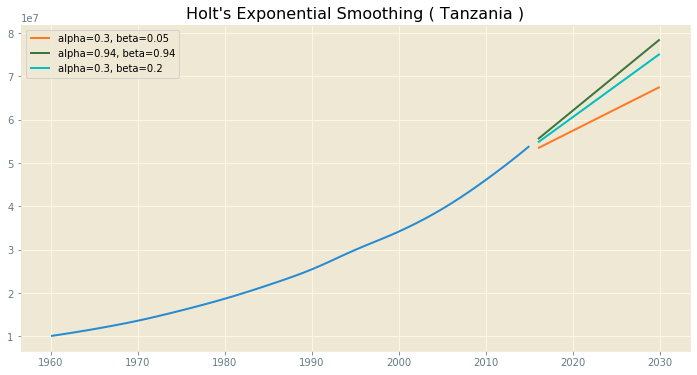

In [149]:

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ind=[i for i in range(2016,2031)]
# ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
#     ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(ind, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing ( Tanzania )")
plt.legend();

In [150]:
print('The percentage of differnce between Actual and Forecasted result for Tanzania:')
f1=np.round((pred1[0]-test.iloc[0])/test.iloc[0]*100,3)
f2=np.round((pred2[0]-test.iloc[0])/test.iloc[0]*100,3)
f3=np.round((pred3[0]-test.iloc[0])/test.iloc[0]*100,3)
print("Total_Population for model with alpha= 0.3 and beta=0.05: ",f1.loc['Total_Population'],'%')
print("Total_Population for model with alpha= 0.9 and beta=0.57: ",f2.loc['Total_Population'],'%')
print("Total_Population for model with alpha= 0.3 and beta=0.2 : ",f3.loc['Total_Population'],'%')

The percentage of differnce between Actual and Forecasted result for Tanzania:
Total_Population for model with alpha= 0.3 and beta=0.05:  -3.872 %
Total_Population for model with alpha= 0.9 and beta=0.57:  -0.095 %
Total_Population for model with alpha= 0.3 and beta=0.2 :  -1.473 %


In [151]:
print(forecast_accuracy(pred2[0],test.iloc[0]))

99.99905
